In [75]:
from operator import add
from typing import List, TypedDict, Optional, Annotated, Dict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END


# The structure of the logs
class Logs(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]


# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    docs: List[Logs]
    failures: List[Logs]
    fa_summary: str


def get_failures(state):
    docs = state["docs"]
    failures = [doc for doc in docs if "grade" in doc]
    return {"failures": failures}


def generate_summary(state):
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary}

# Create the subgraph
# Add nodes
fa_builder = StateGraph(FailureAnalysisState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
# add edges
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)


# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    docs: List[Logs]
    qs_summary: str
    report: str


def generate_summary(state):
    docs = state["docs"]
    # Add fxn: summary = summarize(docs)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary}


def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}


def format_report_for_slack(state):
    report = state["report"]
    # Add fxn: formatted_report = report_format(report)
    formatted_report = "foo bar"
    return {"report": formatted_report}


qs_builder = StateGraph(QuestionSummarizationState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_node("format_report_for_slack", format_report_for_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", "format_report_for_slack")
qs_builder.add_edge("format_report_for_slack", END)

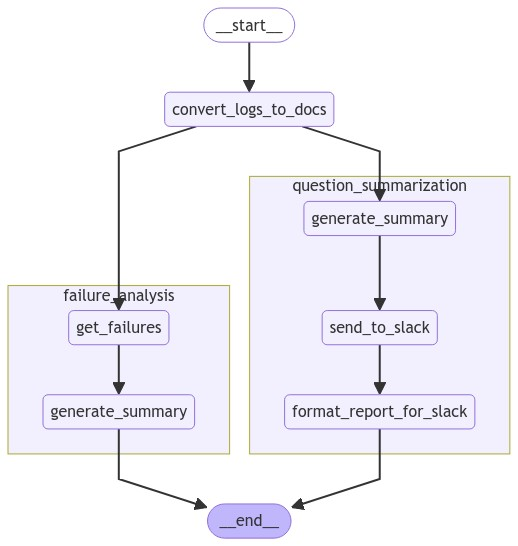

In [76]:
# Dummy logs
question_answer = Logs(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Logs(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)


# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: Annotated[List[Dict], add]
    docs: Annotated[List[Logs], add]  # This will be used in sub-graphs
    fa_summary: str  # This will be generated in the FA sub-graph
    report: str  # This will be generated in the QS sub-graph


def convert_logs_to_docs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    docs = [question_answer, question_answer_feedback]
    return {"docs": docs}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("convert_logs_to_docs", convert_logs_to_docs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "convert_logs_to_docs")
entry_builder.add_edge("convert_logs_to_docs", "failure_analysis")
entry_builder.add_edge("convert_logs_to_docs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [77]:
raw_logs = [{"foo": "bar"}, {"foo": "baz"}]
graph.invoke({"raw_logs": raw_logs}, debug=False)

CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.
CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.


{'raw_logs': [{'foo': 'bar'}, {'foo': 'baz'}],
 'docs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'},
  {'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss 

#### Customer reducer function to manage state

In [78]:
from typing import Annotated

from typing_extensions import TypedDict


def reduce_list(left: list | None, right: list | None) -> list:
    if not left:
        left = []
    if not right:
        right = []
    return left + right


class ChildState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


class ParentState(TypedDict):
    name: str
    path: Annotated[list[str], reduce_list]


child_builder = StateGraph(ChildState)

child_builder.add_node("child_start", lambda state: {"path": ["child_start"]})
child_builder.add_node("child_middle", lambda state: {"path": ["child_middle"]})
child_builder.add_node("child_end", lambda state: {"path": ["child_end"]})

child_builder.add_edge(START, "child_start")
child_builder.add_edge("child_start", "child_middle")
child_builder.add_edge("child_middle", "child_end")
child_builder.add_edge("child_end", END)

builder = StateGraph(ParentState)

builder.add_node("grandparent", lambda state: {"path": ["grandparent"]})
builder.add_edge(START, "grandparent")
builder.add_node("parent", lambda state: {"path": ["parent"]})
builder.add_node("child", child_builder.compile())
builder.add_node("sibling", lambda state: {"path": ["sibling"]})
builder.add_node("fin", lambda state: {"path": ["fin"]})

# Add connections
builder.add_edge("grandparent", "parent")
builder.add_edge("parent", "child")
builder.add_edge("parent", "sibling")
builder.add_edge("child", "fin")
builder.add_edge("sibling", "fin")
builder.add_edge("fin", END)
graph = builder.compile()

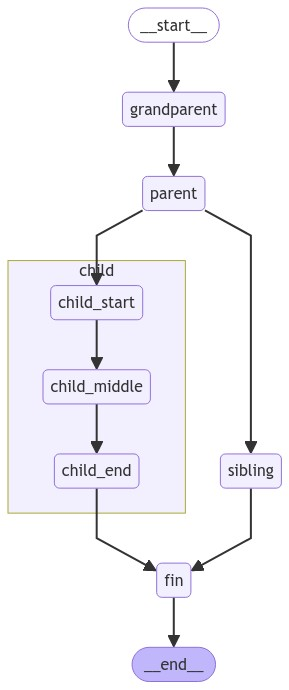

In [79]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [80]:
graph.invoke({"name": "test"}, debug=True)

CallbackManager.merge(): Parent run IDs do not match. Using the parent run ID of the first callback manager.


[-2:checkpoint] State at the end of step -2:
{'path': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'name': 'test'}
[0:writes] Finished step 0 with writes to 1 channel:
- name -> 'test'
[-2:checkpoint] State at the end of step -2:
{'name': 'test', 'path': []}
[1:tasks] Starting step 1 with 1 task:
- grandparent -> {'name': 'test', 'path': []}
[1:writes] Finished step 1 with writes to 1 channel:
- path -> ['grandparent']
[-2:checkpoint] State at the end of step -2:
{'name': 'test', 'path': ['grandparent']}
[2:tasks] Starting step 2 with 1 task:
- parent -> {'name': 'test', 'path': ['grandparent']}
[2:writes] Finished step 2 with writes to 1 channel:
- path -> ['parent']
[-2:checkpoint] State at the end of step -2:
{'name': 'test', 'path': ['grandparent', 'parent']}
[3:tasks] Starting step 3 with 2 tasks:
- child -> {'name': 'test', 'path': ['grandparent', 'parent']}
- sibling -> {'name': 'test', 'path': ['grandparent', 'parent']}
[3:writes] Finished step 3 with writes to 2 

{'name': 'test',
 'path': ['grandparent',
  'parent',
  'grandparent',
  'parent',
  'child_start',
  'child_middle',
  'child_end',
  'sibling',
  'fin']}

In [95]:
import operator
from typing import Annotated, Sequence, Any

from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph


class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]
    which: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}


builder = StateGraph(State)
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_edge(START, "a")
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))
builder.add_node("e", ReturnNodeValue("I'm E"))


def route_bc_or_cd(state: State) -> Sequence[str]:
    if state["which"] == "cd":
        return ["c", "d"]
    return ["b", "c"]



intermediates = ["b", "c", "d"]

dict_intermediates = {"b": "b", "c": "c", "d": "d"}
builder.add_conditional_edges(
    "a",
    route_bc_or_cd,
    # dict_intermediates,
)
for node in intermediates:
    builder.add_edge(node, "e")


builder.add_edge("e", END)
graph = builder.compile()

In [99]:
graph.invoke({"aggregate": [], "which": "cd"})

Adding I'm A to []
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A"]
Adding I'm E to ["I'm A", "I'm C", "I'm D"]


{'aggregate': ["I'm A", "I'm C", "I'm D", "I'm E"], 'which': 'cd'}